## Part 1: Regression ( Predicting if stay is >4 days or <4 days) using original transformer architecture

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np

# Load the processed data from the previous step
try:
    data = np.load('../outputs/dl_sequences.npz')
    # Use binary target for this example
    X_train_seq = data['X_train_seq']
    X_val_seq = data['X_val_seq']
    X_test_seq = data['X_test_seq']
    
    X_train_static = data['X_train_static']
    X_val_static = data['X_val_static']
    X_test_static = data['X_test_static']
    
    y_train = data['y_train_binary']
    y_val = data['y_val_binary']
    y_test = data['y_test_binary']
    
    mask_train = data['mask_train']
    mask_val = data['mask_val']
    mask_test = data['mask_test']
    
    # Get metadata for model size
    N_TEMPORAL_FEATURES = X_train_seq.shape[-1]
    N_STATIC_FEATURES = X_train_static.shape[-1]
    SEQUENCE_LENGTH = X_train_seq.shape[1]
    
except FileNotFoundError:
    print("Error: dl_sequences.npz not found. Rerun the data preprocessing script.")
    raise

print(f"Data loaded for Transformer:")
print(f"  Temporal features (D_model): {N_TEMPORAL_FEATURES}")
print(f"  Static features: {N_STATIC_FEATURES}")
print(f"  Sequence Length (T): {SEQUENCE_LENGTH}")


# %% Define PyTorch Dataset (Re-implementing for completeness)
class ICUDataset(Dataset):
    """Custom Dataset for loading sequence and static features with masks."""
    def __init__(self, sequences, static, labels, masks):
        self.sequences = torch.FloatTensor(sequences)
        self.static = torch.FloatTensor(static)
        self.labels = torch.FloatTensor(labels)
        self.masks = torch.BoolTensor(masks) # Masks for Transformer
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],      # (T, N_TEMPORAL_FEATURES)
            'static': self.static[idx],           # (N_STATIC_FEATURES,)
            'label': self.labels[idx],            # scalar
            'mask': self.masks[idx]               # (T,)
        }

Data loaded for Transformer:
  Temporal features (D_model): 34
  Static features: 5
  Sequence Length (T): 24


In [14]:
# Define Positional Encoding Layer
class PositionalEncoding(nn.Module):
    """
    Implements the standard sinusoidal positional encoding (PE) used in the
    original Transformer paper. PE is added to the input embeddings.
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        # Calculate the divisor for the sinusoidal function
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        # Create the PE matrix
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term) # Even indices
        pe[:, 0, 1::2] = torch.cos(position * div_term) # Odd indices
        
        self.register_buffer('pe', pe) # Register as a buffer, not a parameter

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape (seq_len, batch_size, d_model)
        Returns:
            x: Tensor with PE added, shape (seq_len, batch_size, d_model)
        """
        # Add PE to the input. Truncate PE to the length of the input sequence.
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [15]:
class ICUTransformer(nn.Module):
    def __init__(self, 
                 n_temporal_features: int,
                 d_model: int, 
                 n_static: int,
                 n_heads: int = 8, 
                 n_layers: int = 3, 
                 dropout: float = 0.1, 
                 dim_feedforward: int = 2048):
        super().__init__()
        
        self.d_model = d_model
        
        # 1. Temporal Feature Embedding/Projector (if d_model != n_temporal_features)
        # Since n_temporal_features is typically the desired d_model, we skip a separate projection
        # If the features were categorical, an embedding layer would be used.
        self.feature_projector = nn.Linear(n_temporal_features, d_model)
        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # 3. Transformer Encoder Stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=False # Input expects (Seq_len, Batch, Features)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 4. Static Feature MLP
        # Process static features down to a size that can be easily concatenated
        # In this case, we project it to the same size as the temporal features (d_model)
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, d_model)
        )
        
        # 5. Classification Head
        # Concatenate: Transformer Output (d_model) + Static MLP Output (d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model * 2, d_model), # * 2 because of concatenation
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1) # Single output for binary classification
        )
        
    def forward(self, src: torch.Tensor, static: torch.Tensor, src_mask: torch.Tensor = None):
        # src shape: (Batch, Seq_len, Features) -> (N, T, D)
        src = self.feature_projector(src)
        
        # 1. Permute src to Transformer standard: (Seq_len, Batch, Features) -> (T, N, D)
        src = src.permute(1, 0, 2)
        
        # 2. Add Positional Encoding
        src = self.pos_encoder(src) # (T, N, D)
        
        # 3. Transformer Encoder
        # The src_mask needs to be a boolean tensor (Batch, Seq_len)
        # Note: PyTorch's MHA expects a mask of shape (N, T) for batch_first=False
        # Since we use batch_first=False, we pass src_key_padding_mask as (N, T)
        # The mask passed from DataLoader is (N, T)
        output_temporal = self.transformer_encoder(
            src, 
            src_key_padding_mask=src_mask
        ) # (T, N, D)
        
        # 4. Sequence Pooling/Aggregation
        # We use the output of the last time step for classification
        # (This is analogous to the [CLS] token used in NLP)
        # We take the output at the last time step: output_temporal[-1, :, :]
        # Shape: (Batch, D)
        temporal_representation = output_temporal[-1, :, :] 
        
        # 5. Process Static Features
        static_representation = self.static_mlp(static) # (Batch, D)
        
        # 6. Concatenate and Classify
        combined_representation = torch.cat(
            [temporal_representation, static_representation], 
            dim=1
        ) # (Batch, 2*D)
        
        output = self.classifier(combined_representation).squeeze(-1) # (Batch,)
        
        return output



In [20]:
# %% Initialize and Configure Model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model hyper-parameters
N_TEMPORAL_FEATURES = X_train_seq.shape[-1] # This is 34
N_STATIC_FEATURES = X_train_static.shape[-1]
N_HEADS = 8                      # D_MODEL must be divisible by N_HEADS (35 not div by 8, use 7 or project D_MODEL to 32/64)

N_LAYERS = 3
DROPOUT = 0.1
# Adjust D_MODEL if N_TEMPORAL_FEATURES is not easily divisible
if N_TEMPORAL_FEATURES % N_HEADS != 0:
    print(f"Warning: D_MODEL ({N_TEMPORAL_FEATURES}) is not divisible by N_HEADS ({N_HEADS}). Setting D_MODEL=32 for compatibility.")
    D_MODEL = 32
    # You would typically add a linear layer to project N_TEMPORAL_FEATURES to D_MODEL=32

model = ICUTransformer(
    n_temporal_features=N_TEMPORAL_FEATURES, # Pass the raw input size (34)
    d_model=D_MODEL,                       # Pass the target size (32)
    n_static=N_STATIC_FEATURES,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

# Training hyper-parameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
N_EPOCHS = 50

# Loss Function (BCEWithLogitsLoss is numerically stable for binary classification)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\nModel initialized and ready for training on {DEVICE}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/Users/suki/mamba/envs/main_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Model initialized and ready for training on cpu
Model Parameters: 416,385


In [21]:
train_dataset = ICUDataset(X_train_seq, X_train_static, y_train, mask_train)
val_dataset = ICUDataset(X_val_seq, X_val_static, y_val, mask_val)
test_dataset = ICUDataset(X_test_seq, X_test_static, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created: Train batches={len(train_loader)}, Val batches={len(val_loader)}")

DataLoaders created: Train batches=55, Val batches=12


In [22]:
from sklearn.metrics import roc_auc_score, average_precision_score
import torch.nn.functional as F

from pathlib import Path


MODEL_DIR = Path("../models") 
MODEL_DIR.mkdir(exist_ok=True)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in loader:
        sequence = batch['sequence'].to(device)
        static = batch['static'].to(device)
        labels = batch['label'].to(device)
        mask = batch['mask'].to(device)

        
        optimizer.zero_grad()

        
        outputs = model(sequence, static, src_mask=mask) 
        
        
        loss = criterion(outputs, labels.float()) # labels must be float for BCEWithLogitsLoss
        
    
        loss.backward()
        
        # Clip gradients to prevent exploding gradients 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item() * sequence.size(0)
        
    return total_loss / len(loader.dataset)


def evaluate_model(model, loader, criterion, device):
    
    model.eval()
    total_loss = 0
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in loader:
            sequence = batch['sequence'].to(device)
            static = batch['static'].to(device)
            labels = batch['label'].to(device)
            mask = batch['mask'].to(device)

            outputs = model(sequence, static, src_mask=mask) 
            
          
            loss = criterion(outputs, labels.float())
            total_loss += loss.item() * sequence.size(0)
            
           
            probs = torch.sigmoid(outputs)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_labels_np = np.array(all_labels)
    all_probs_np = np.array(all_probs)
    
    # Calculate AUC
    if len(np.unique(all_labels_np)) > 1:
        auc = roc_auc_score(all_labels_np, all_probs_np)
        auprc = average_precision_score(all_labels_np, all_probs_np)
    else:
        # Handle the case where the batch/dataset only contains one class
        auc = float('nan') 
        print("Warning: AUC cannot be calculated (only one class present in evaluation set).")

    return avg_loss, auc, auprc


print("\n" + "=" * 60)
print("STARTING MODEL TRAINING")
print("=" * 60)


train_loss_history = []
val_loss_history = []
val_auroc_history = []
val_auprc_history = []

best_val_loss = float('inf')
early_stop_patience = 5
patience_counter = 0

for epoch in range(N_EPOCHS):
    
    # --- Training Step ---
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # --- Evaluation Step ---
    val_loss, val_auc, val_auprc = evaluate_model(model, val_loader, criterion, DEVICE)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_auroc_history.append(val_auc)
    val_auprc_history.append(val_auprc)
    
    print(f"Epoch {epoch+1:02d}/{N_EPOCHS}: | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val AUROC: {val_auc:.4f} | "
          f"Val AUPRC: {val_auprc:.4f}") #
    
    # --- Checkpoint and Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save the best model state
        torch.save(model.state_dict(), '../models/ best_transformer_model.pt')
        print(f"  -> Model saved. New best Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement.")
        break

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)



try:
    model.load_state_dict(torch.load(MODEL_DIR /'best_transformer_model.pt'))
    print(f"Model saved to {MODEL_DIR / 'best_transformer_model.pt'}")
except FileNotFoundError:
    print("Could not load best model. Using current model state for test evaluation.")

test_loss, test_auc, test_auprc = evaluate_model(model, test_loader, criterion, DEVICE)

print(f"\nFinal Test Set Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test AUC: {test_auc:.4f}")
print(f"  Test AUC: {test_auprc:.4f}")
# %%


STARTING MODEL TRAINING
Epoch 01/50: | Train Loss: 0.5907 | Val Loss: 0.5361 | Val AUROC: 0.7673 | Val AUPRC: 0.5234
  -> Model saved. New best Val Loss: 0.5361
Epoch 02/50: | Train Loss: 0.5153 | Val Loss: 0.4704 | Val AUROC: 0.7819 | Val AUPRC: 0.5471
  -> Model saved. New best Val Loss: 0.4704
Epoch 03/50: | Train Loss: 0.4685 | Val Loss: 0.4364 | Val AUROC: 0.7940 | Val AUPRC: 0.5715
  -> Model saved. New best Val Loss: 0.4364
Epoch 04/50: | Train Loss: 0.4467 | Val Loss: 0.4218 | Val AUROC: 0.7931 | Val AUPRC: 0.5740
  -> Model saved. New best Val Loss: 0.4218
Epoch 05/50: | Train Loss: 0.4323 | Val Loss: 0.4103 | Val AUROC: 0.8019 | Val AUPRC: 0.5756
  -> Model saved. New best Val Loss: 0.4103
Epoch 06/50: | Train Loss: 0.4245 | Val Loss: 0.4000 | Val AUROC: 0.8134 | Val AUPRC: 0.5799
  -> Model saved. New best Val Loss: 0.4000
Epoch 07/50: | Train Loss: 0.4157 | Val Loss: 0.3972 | Val AUROC: 0.8138 | Val AUPRC: 0.5869
  -> Model saved. New best Val Loss: 0.3972
Epoch 08/50: | T

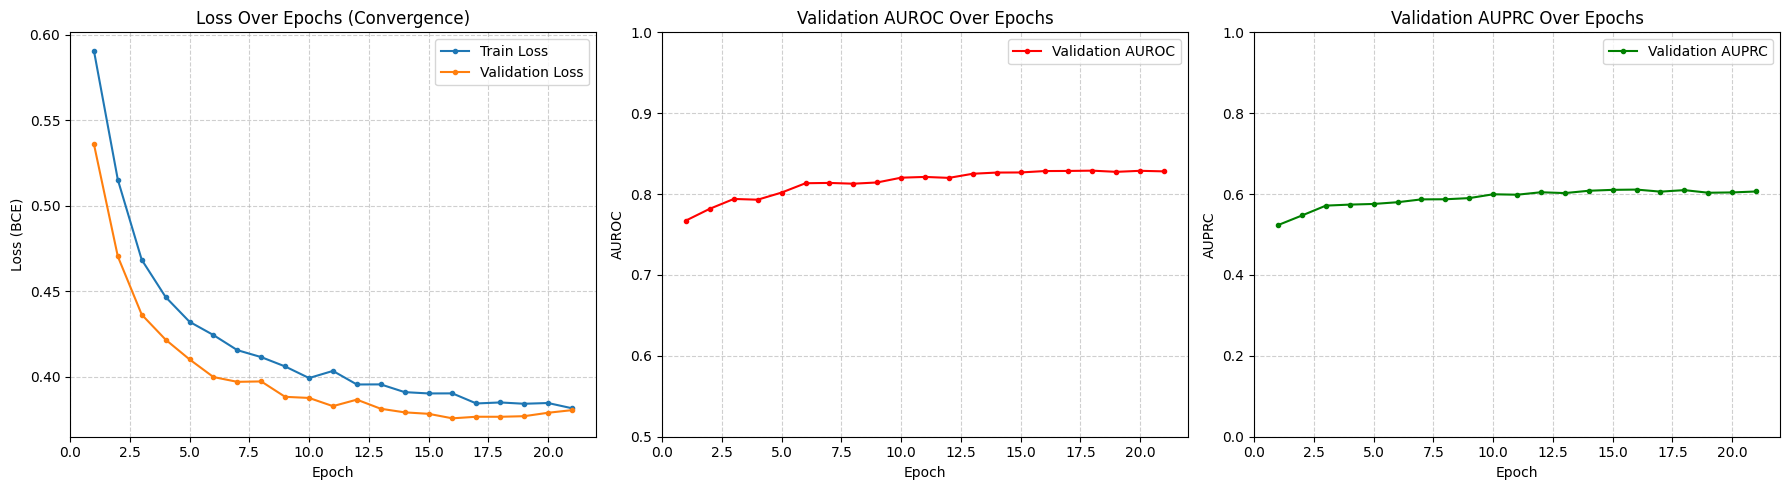


Training history plots displayed successfully.


In [23]:

import matplotlib.pyplot as plt


epochs_run = len(val_loss_history)
epochs = range(1, epochs_run + 1)

plt.figure(figsize=(18, 5))

# --- Plot 1: Loss Curve ---
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', marker='.')
plt.plot(epochs, val_loss_history, label='Validation Loss', marker='.')
plt.title('Loss Over Epochs (Convergence)')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: AUROC Curve ---
plt.subplot(1, 3, 2)
plt.plot(epochs, val_auroc_history, label='Validation AUROC', color='red', marker='.')
plt.title('Validation AUROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.ylim(0.5, 1.0) # AUC should be > 0.5 (random)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot 3: AUPRC Curve ---
plt.subplot(1, 3, 3)
plt.plot(epochs, val_auprc_history, label='Validation AUPRC', color='green', marker='.')
plt.title('Validation AUPRC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUPRC')
plt.ylim(0.0, 1.0) # AUPRC range is 0 to 1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# %% 
print("\nTraining history plots displayed successfully.")